# SUMO_DNDC

A surrogate model to LandscapeDNDC for faster inference... 😎

The plan is to model a time-series via a LSTM. Trainging data is provided by LandscapeDNDC model runs.

<figure>
    <img src="../images/sketch.png" alt="Sketch" width="400"/>
    <figcaption>Fig. 1: A sketch of the model setup</figcaption>
</figure>

## Embeddings

We encode the site state in one embedding layer. The current format is:

### General site info  

| id   | variable | min     | max     |      
|------|----------|---------|---------|
| 0    | site lat | NA      | NA      |
| 1    | site lon | NA      | NA      |
| 2    | site ele | 0       | NA      |


### Airchemistry info  

| id   | variable | min     | max     |      
|------|----------|---------|---------|
| 3    | nh4      | 0       | NA      |
| 4    | no3      | 0       | NA      |
| 5    | ch4      | 0       | NA      |
| 6    | co2      | 0       | NA      |
| 7    | o3       | 0       | NA      |
| 8    | nh3      | 0       | NA      |
| 9    | no2      | 0       | NA      |
| 10   | no       | 0       | NA      |


### Soil properties

Soil variables are aggregated/ expanded to 10cm depth buckets.
The top 50cm of any profile is used (depth and split are used
to preprocess soil strata to fixed 10cm bucket format. SKS is
omitted.

| id   | variable | min     | max     |      
|------|----------|---------|---------|
| 11   | bd (0)   | 0       | NA      |
| 12   | clay (0) | 0       | NA      |
| 13   | corg (0) | 0       | NA      |
| 14   | norg (0) | 0       | NA      |
| 15   | ph (0)   | 0       | NA      |
| 16   | sand (0) | 0       | NA      |
| 17   | scel (0) | 0       | NA      |
| 18   | silt (0) | 0       | NA      |
| 19   | wcmin (0)| 0       | NA      |
| 20   | wcmax (0)| 0       | NA      |
| ...  | ...      | ...     | ...     |
| 60   | wcmax (4)| 0       | NA      |

### Other

Not yet considered... Possibly site history?

----

In [383]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '..') # Add directory above current directory to path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parsing DNDC raw files

### Input files (TS and static)

In [384]:
from sumo_dndc.parser import Parser, InFile, OutFile

In [385]:
climate = Parser(InFile.CLIMATE, "../data/DE_fendt/DE_fendt_climate.txt", vars=['tavg', 'prec', 'grad'])
climate

Parser: InFile.CLIMATE, ../data/DE_fendt/DE_fendt_climate.txt
Data excerpt:
                tavg  prec       grad
date                                 
2010-01-01 -1.558333   0.8  23.501792
2010-02-01 -1.248194   0.6  26.181847
2010-03-01 -4.909329   0.0  19.080529
2010-04-01 -8.494789   0.0  29.938732
2010-05-01 -8.978889   0.0  12.868179

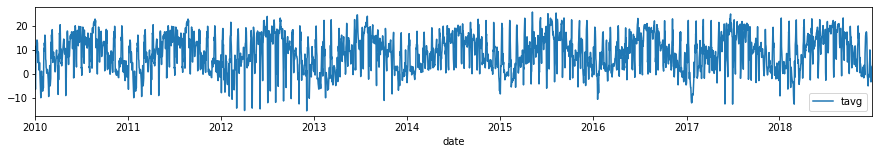

In [415]:
climate.data.plot(y='tavg', figsize=(15,2))

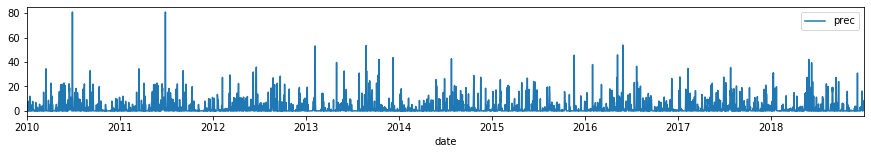

In [416]:
climate.data.plot(y='prec', figsize=(15,2))

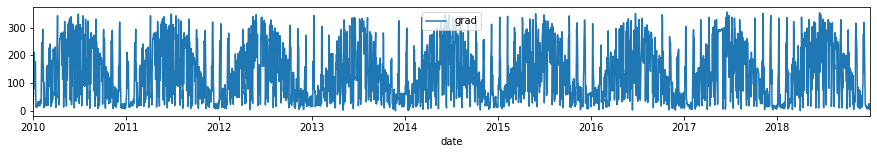

In [417]:
climate.data.plot(y='grad', figsize=(15,2))

### Parse results file

In [389]:
results = Parser(OutFile.DAILY, 
                 "../data/DE_fendt/DE_fendt_output/DE_fendt_soilchemistry-daily.txt",
                 vars=["dN_n2o_emis[kgNha-1]"])

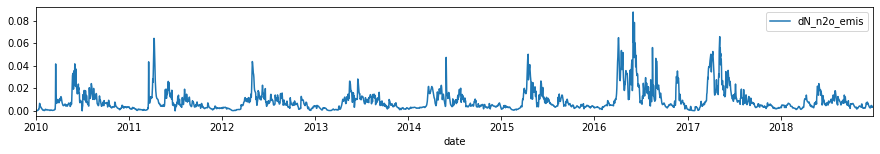

In [418]:
results.data_nounits.plot(y='dN_n2o_emis', figsize=(15,2))

In [414]:
df = pd.concat([climate.data, results.data_nounits], sort=False, axis=1)
df.head()

,tavg,prec,grad,dN_n2o_emis
2010-01-01,-1.558333,0.8,23.501792,0.000321
2010-02-01,-1.248194,0.6,26.181847,0.000334
2010-03-01,-4.909329,0.0,19.080529,0.000697
2010-04-01,-8.494789,0.0,29.938732,0.008835
2010-05-01,-8.978889,0.0,12.868179,0.005088


In [392]:
site = Parser(InFile.SITE, "../data/DE_fendt/DE_fendt_site.xml")

In [393]:
site

Parser: InFile.SITE, ../data/DE_fendt/DE_fendt_site.xml
Data excerpt:
<?xml version="1.0" encoding="utf8"?>
<soil>
	<general humus="MULL" litterheight="" soil="LOAM" usehistory="grassland"/>
	<layers>
		<layer bd="0.74" clay="0.272" corg="0.0679" depth="50" norg="0.0066" ph="5.1" sand="0.305" scel="0.00" silt="0.403" sks="0.020" split="3" wcmax="500" wcmin="235"/>
		<layer bd="1.10" clay="0.252" corg="0.0435" depth="150" norg="0.0048" ph="6.6" sand="0.355" scel="0.038" silt="0.403" sks="0.020" split="8" wcmax="460" wcmin="235"/>

In [268]:
airchem

Parser: InFile.AIRCHEM, ../data/DE_fendt/DE_fendt_airchem.txt
Data excerpt:
   nh4  no3  ch4    co2   o3  nh3  no2   no
0  1.4  0.9  0.0  400.0  0.0  0.0  0.0  0.0

In [101]:
climate.encode(vars=['tavg','prec','xxx'])

In [100]:
climate._data

,prec,tavg,tmax,tmin,grad,rh,press,wind
date,,,,,,,,
2010-01-01,0.80,-1.558333,-0.12,-3.10,23.501792,89.145833,948.694444,1.396806
2010-02-01,0.60,-1.248194,0.00,-3.04,26.181847,83.873333,948.902778,1.837500
2010-03-01,0.00,-4.909329,1.13,-9.49,19.080529,82.456224,950.587413,1.143014
2010-04-01,0.00,-8.494789,-4.16,-12.14,29.938732,85.451761,946.394366,0.810704
2010-05-01,0.00,-8.978889,0.28,-14.18,12.868179,85.121875,942.763889,0.786667
...,...,...,...,...,...,...,...,...
2018-12-27,0.00,-3.086736,3.60,-8.30,25.131053,87.626042,956.263194,0.610903
2018-12-28,0.00,-1.394653,6.90,-5.60,13.828439,85.896319,957.034722,0.980764
2018-12-29,0.78,-1.132708,2.80,-7.00,22.725735,84.733611,960.312500,1.585903
